# Train Low Test Models

This notebook is a streamlined notebook for generating minima of low test accuracy through three different means:
- Dataset Poisoning
- Adding Noise to Data
- Decreasing Dataset Sizes

## Imports

In [1]:
# Standard library
import copy
import os
import sys
import time

# Third-party
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Local package imports
from minima_volume.dataset_funcs import (
    prepare_datasets,
    save_dataset,
    save_model,
)
from minima_volume.train_funcs import evaluate, train

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Input Parameters

In [2]:

# ==============================
# Base Input Parameters
# ==============================
# --- SEEDS ---
data_seed = 11            
model_seed = 1           

# --- Training configuration ---
epochs = 2000            

# --- Dataset configuration ---
base_data_size = 60      
dataset_type = "data"   
dataset_quantities = [0, 600-60, 2000 - 60, 6000 - 60, 20000 - 60, 60000 - 60]

# --- Output configuration ---
base_output_dir = ""     
save_generated_dataset = True   
save_generated_models = True    


## Model + Dataset Specific Code

This is for specific code.

In [3]:
# User specifies the model module name
from minima_volume.models import Fashion_MNIST_model_data as model_module

# Generate dataset
x_base, y_base, x_test, y_test = model_module.get_dataset(
    device = device
)

# MNIST specific initialization parameters
hidden_dims = [256, 128]

# Grab model
model_template = model_module.get_model(hidden_dims=hidden_dims, device=device, seed=model_seed)

# Grab loss and metrics
loss_fn = model_module.get_loss_fn()
other_metrics = model_module.get_additional_metrics()

## Training

We generate the various datasets used to train our models here, before training them. We record the losses, and what each model was trained on.

In [4]:
# ==============================
# Prepare datasets
# ==============================
x_base_train, y_base_train, x_additional, y_additional = prepare_datasets(
    x_base=x_base,
    y_base=y_base,
    dataset_type=dataset_type,
    dataset_quantities=dataset_quantities,
    base_data_size=base_data_size,
    data_seed=data_seed,
    seed_1=None,
    seed_2=None,
)

x_base_train = x_base_train.to(device)
y_base_train = y_base_train.to(device)
x_additional = x_additional.to(device)
y_additional = y_additional.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

# ==============================
# Training loop
# ==============================
all_models = []

for additional_data in dataset_quantities:
    # Assemble training dataset
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    # Initialize model (defined in the model-specific file)
    torch.manual_seed(model_seed)
    model = copy.deepcopy(model_template)
    optimizer = optim.AdamW(model.parameters(), lr=1e-3)
    batch_size = len(x_train)

    # Train model
    train_loss, train_other_metrics, test_loss, test_other_metrics = train(
        model = model,
        x_train = x_train, y_train = y_train,
        x_test = x_test, y_test = y_test,
        loss_fn = loss_fn,
        metrics = other_metrics,
        optimizer = optimizer,
        epochs=epochs,
        batch_size=batch_size,
        verbose_every=100,
    )
    
    # Build dictionary dynamically for additional metrics
    train_metrics_dict = {}
    test_metrics_dict = {}
    if train_other_metrics is not None:
        # train_other_metrics is a list of dicts per epoch
        for metric_name in train_other_metrics[0].keys():  # keys from first epoch
            train_metrics_dict[f"train_{metric_name}"] = [m[metric_name] for m in train_other_metrics]
            test_metrics_dict[f"test_{metric_name}"] = [m[metric_name] for m in test_other_metrics]
    
    # Store results
    trained_model = {
        "model": model,
        "train_loss": train_loss,
        "test_loss": test_loss,
        "additional_data": additional_data,
        "dataset_type": dataset_type,
        **train_metrics_dict,  # dynamically include additional metrics
        **test_metrics_dict,
    }
    
    all_models.append(trained_model)

    print(f"Completed training with {additional_data} additional samples of {dataset_type}")

    # Free memory (important for large GPU datasets)
    del x_train, y_train
    torch.cuda.empty_cache()


Epoch 1/2000: Train Loss 2.3188 | Test Loss 2.1709 | accs Train 0.1167 Test 0.2987


Epoch 100/2000: Train Loss 0.0004 | Test Loss 2.2258 | accs Train 1.0000 Test 0.6275


Epoch 200/2000: Train Loss 0.0002 | Test Loss 2.3143 | accs Train 1.0000 Test 0.6289


Epoch 300/2000: Train Loss 0.0001 | Test Loss 2.3897 | accs Train 1.0000 Test 0.6296


Epoch 400/2000: Train Loss 0.0001 | Test Loss 2.4529 | accs Train 1.0000 Test 0.6291


Epoch 500/2000: Train Loss 0.0001 | Test Loss 2.5045 | accs Train 1.0000 Test 0.6297


Epoch 600/2000: Train Loss 0.0000 | Test Loss 2.5488 | accs Train 1.0000 Test 0.6291


Epoch 700/2000: Train Loss 0.0000 | Test Loss 2.5857 | accs Train 1.0000 Test 0.6291


Epoch 800/2000: Train Loss 0.0000 | Test Loss 2.6190 | accs Train 1.0000 Test 0.6293


Epoch 900/2000: Train Loss 0.0000 | Test Loss 2.6478 | accs Train 1.0000 Test 0.6293


Epoch 1000/2000: Train Loss 0.0000 | Test Loss 2.6701 | accs Train 1.0000 Test 0.6296


Epoch 1100/2000: Train Loss 0.0000 | Test Loss 2.6934 | accs Train 1.0000 Test 0.6295


Epoch 1200/2000: Train Loss 0.0000 | Test Loss 2.7149 | accs Train 1.0000 Test 0.6299


Epoch 1300/2000: Train Loss 0.0000 | Test Loss 2.7353 | accs Train 1.0000 Test 0.6295


Epoch 1400/2000: Train Loss 0.0000 | Test Loss 2.7549 | accs Train 1.0000 Test 0.6295


Epoch 1500/2000: Train Loss 0.0000 | Test Loss 2.7726 | accs Train 1.0000 Test 0.6300


Epoch 1600/2000: Train Loss 0.0000 | Test Loss 2.7894 | accs Train 1.0000 Test 0.6301


Epoch 1700/2000: Train Loss 0.0000 | Test Loss 2.8052 | accs Train 1.0000 Test 0.6308


Epoch 1800/2000: Train Loss 0.0000 | Test Loss 2.8203 | accs Train 1.0000 Test 0.6304


Epoch 1900/2000: Train Loss 0.0000 | Test Loss 2.8345 | accs Train 1.0000 Test 0.6311


Epoch 2000/2000: Train Loss 0.0000 | Test Loss 2.8483 | accs Train 1.0000 Test 0.6312
Completed training with 0 additional samples of data
Epoch 1/2000: Train Loss 2.3093 | Test Loss 2.1438 | accs Train 0.0967 Test 0.4473


Epoch 100/2000: Train Loss 0.0057 | Test Loss 1.0452 | accs Train 1.0000 Test 0.7874


Epoch 200/2000: Train Loss 0.0011 | Test Loss 1.2403 | accs Train 1.0000 Test 0.7899


Epoch 300/2000: Train Loss 0.0005 | Test Loss 1.3409 | accs Train 1.0000 Test 0.7892


Epoch 400/2000: Train Loss 0.0003 | Test Loss 1.4114 | accs Train 1.0000 Test 0.7896


Epoch 500/2000: Train Loss 0.0002 | Test Loss 1.4665 | accs Train 1.0000 Test 0.7890


Epoch 600/2000: Train Loss 0.0001 | Test Loss 1.5112 | accs Train 1.0000 Test 0.7886


Epoch 700/2000: Train Loss 0.0001 | Test Loss 1.5497 | accs Train 1.0000 Test 0.7881


Epoch 800/2000: Train Loss 0.0001 | Test Loss 1.5830 | accs Train 1.0000 Test 0.7885


Epoch 900/2000: Train Loss 0.0001 | Test Loss 1.6122 | accs Train 1.0000 Test 0.7883


Epoch 1000/2000: Train Loss 0.0000 | Test Loss 1.6384 | accs Train 1.0000 Test 0.7885


Epoch 1100/2000: Train Loss 0.0000 | Test Loss 1.6622 | accs Train 1.0000 Test 0.7886


Epoch 1200/2000: Train Loss 0.0000 | Test Loss 1.6840 | accs Train 1.0000 Test 0.7890


Epoch 1300/2000: Train Loss 0.0000 | Test Loss 1.7041 | accs Train 1.0000 Test 0.7887


Epoch 1400/2000: Train Loss 0.0000 | Test Loss 1.7229 | accs Train 1.0000 Test 0.7886


Epoch 1500/2000: Train Loss 0.0000 | Test Loss 1.7404 | accs Train 1.0000 Test 0.7887


Epoch 1600/2000: Train Loss 0.0000 | Test Loss 1.7568 | accs Train 1.0000 Test 0.7885


Epoch 1700/2000: Train Loss 0.0000 | Test Loss 1.7725 | accs Train 1.0000 Test 0.7885


Epoch 1800/2000: Train Loss 0.0000 | Test Loss 1.7875 | accs Train 1.0000 Test 0.7885


Epoch 1900/2000: Train Loss 0.0000 | Test Loss 1.8017 | accs Train 1.0000 Test 0.7886


Epoch 2000/2000: Train Loss 0.0000 | Test Loss 1.8153 | accs Train 1.0000 Test 0.7885
Completed training with 540 additional samples of data
Epoch 1/2000: Train Loss 2.3028 | Test Loss 2.1345 | accs Train 0.1110 Test 0.4164


Epoch 100/2000: Train Loss 0.0670 | Test Loss 0.6481 | accs Train 0.9890 Test 0.8219


Epoch 200/2000: Train Loss 0.0050 | Test Loss 0.9581 | accs Train 1.0000 Test 0.8194


Epoch 300/2000: Train Loss 0.0016 | Test Loss 1.1012 | accs Train 1.0000 Test 0.8186


Epoch 400/2000: Train Loss 0.0008 | Test Loss 1.1906 | accs Train 1.0000 Test 0.8185


Epoch 500/2000: Train Loss 0.0005 | Test Loss 1.2565 | accs Train 1.0000 Test 0.8182


Epoch 600/2000: Train Loss 0.0003 | Test Loss 1.3081 | accs Train 1.0000 Test 0.8186


Epoch 700/2000: Train Loss 0.0002 | Test Loss 1.3497 | accs Train 1.0000 Test 0.8183


Epoch 800/2000: Train Loss 0.0002 | Test Loss 1.3856 | accs Train 1.0000 Test 0.8182


Epoch 900/2000: Train Loss 0.0001 | Test Loss 1.4197 | accs Train 1.0000 Test 0.8187


Epoch 1000/2000: Train Loss 0.0001 | Test Loss 1.4556 | accs Train 1.0000 Test 0.8180


Epoch 1100/2000: Train Loss 0.0001 | Test Loss 1.4925 | accs Train 1.0000 Test 0.8172


Epoch 1200/2000: Train Loss 0.0001 | Test Loss 1.5172 | accs Train 1.0000 Test 0.8174


Epoch 1300/2000: Train Loss 0.0001 | Test Loss 1.5387 | accs Train 1.0000 Test 0.8173


Epoch 1400/2000: Train Loss 0.0001 | Test Loss 1.5586 | accs Train 1.0000 Test 0.8173


Epoch 1500/2000: Train Loss 0.0000 | Test Loss 1.5774 | accs Train 1.0000 Test 0.8173


Epoch 1600/2000: Train Loss 0.0000 | Test Loss 1.5950 | accs Train 1.0000 Test 0.8174


Epoch 1700/2000: Train Loss 0.0000 | Test Loss 1.6115 | accs Train 1.0000 Test 0.8175


Epoch 1800/2000: Train Loss 0.0000 | Test Loss 1.6271 | accs Train 1.0000 Test 0.8173


Epoch 1900/2000: Train Loss 0.0000 | Test Loss 1.6420 | accs Train 1.0000 Test 0.8177


Epoch 2000/2000: Train Loss 0.0000 | Test Loss 1.6562 | accs Train 1.0000 Test 0.8174
Completed training with 1940 additional samples of data
Epoch 1/2000: Train Loss 2.3036 | Test Loss 2.1329 | accs Train 0.1100 Test 0.4207


Epoch 100/2000: Train Loss 0.2368 | Test Loss 0.4494 | accs Train 0.9235 Test 0.8457


Epoch 200/2000: Train Loss 0.0698 | Test Loss 0.5495 | accs Train 0.9873 Test 0.8446


Epoch 300/2000: Train Loss 0.0179 | Test Loss 0.7117 | accs Train 0.9992 Test 0.8430


Epoch 400/2000: Train Loss 0.0098 | Test Loss 0.7892 | accs Train 0.9995 Test 0.8418


Epoch 500/2000: Train Loss 0.0057 | Test Loss 0.8542 | accs Train 1.0000 Test 0.8418


Epoch 600/2000: Train Loss 0.0036 | Test Loss 0.9114 | accs Train 1.0000 Test 0.8401


Epoch 700/2000: Train Loss 0.0025 | Test Loss 0.9623 | accs Train 1.0000 Test 0.8391


Epoch 800/2000: Train Loss 0.0018 | Test Loss 1.0082 | accs Train 1.0000 Test 0.8386


Epoch 900/2000: Train Loss 0.0013 | Test Loss 1.0493 | accs Train 1.0000 Test 0.8395


Epoch 1000/2000: Train Loss 0.0010 | Test Loss 1.0855 | accs Train 1.0000 Test 0.8394


Epoch 1100/2000: Train Loss 0.0008 | Test Loss 1.1186 | accs Train 1.0000 Test 0.8388


Epoch 1200/2000: Train Loss 0.0007 | Test Loss 1.1484 | accs Train 1.0000 Test 0.8384


Epoch 1300/2000: Train Loss 0.0005 | Test Loss 1.1760 | accs Train 1.0000 Test 0.8378


Epoch 1400/2000: Train Loss 0.0004 | Test Loss 1.2014 | accs Train 1.0000 Test 0.8375


Epoch 1500/2000: Train Loss 0.0004 | Test Loss 1.2251 | accs Train 1.0000 Test 0.8373


Epoch 1600/2000: Train Loss 0.0003 | Test Loss 1.2478 | accs Train 1.0000 Test 0.8377


Epoch 1700/2000: Train Loss 0.0003 | Test Loss 1.2695 | accs Train 1.0000 Test 0.8375


Epoch 1800/2000: Train Loss 0.0002 | Test Loss 1.2901 | accs Train 1.0000 Test 0.8375


Epoch 1900/2000: Train Loss 0.0002 | Test Loss 1.3102 | accs Train 1.0000 Test 0.8380


Epoch 2000/2000: Train Loss 0.0002 | Test Loss 1.3292 | accs Train 1.0000 Test 0.8381
Completed training with 5940 additional samples of data
Epoch 1/2000: Train Loss 2.3028 | Test Loss 2.1322 | accs Train 0.1084 Test 0.4232


Epoch 100/2000: Train Loss 0.3146 | Test Loss 0.4033 | accs Train 0.8891 Test 0.8594


Epoch 200/2000: Train Loss 0.1991 | Test Loss 0.3943 | accs Train 0.9325 Test 0.8671


Epoch 300/2000: Train Loss 0.1253 | Test Loss 0.4234 | accs Train 0.9605 Test 0.8688


Epoch 400/2000: Train Loss 0.0790 | Test Loss 0.4823 | accs Train 0.9796 Test 0.8670


Epoch 500/2000: Train Loss 0.0463 | Test Loss 0.5409 | accs Train 0.9916 Test 0.8664


Epoch 600/2000: Train Loss 0.0686 | Test Loss 0.6532 | accs Train 0.9746 Test 0.8533


Epoch 700/2000: Train Loss 0.0185 | Test Loss 0.6702 | accs Train 0.9984 Test 0.8636


Epoch 800/2000: Train Loss 0.0120 | Test Loss 0.7304 | accs Train 0.9993 Test 0.8628


Epoch 900/2000: Train Loss 0.0081 | Test Loss 0.7842 | accs Train 0.9997 Test 0.8623


Epoch 1000/2000: Train Loss 0.0056 | Test Loss 0.8326 | accs Train 0.9999 Test 0.8616


Epoch 1100/2000: Train Loss 0.0041 | Test Loss 0.8756 | accs Train 1.0000 Test 0.8615


Epoch 1200/2000: Train Loss 0.0031 | Test Loss 0.9143 | accs Train 1.0000 Test 0.8615


Epoch 1300/2000: Train Loss 0.0024 | Test Loss 0.9501 | accs Train 1.0000 Test 0.8607


Epoch 1400/2000: Train Loss 0.0019 | Test Loss 0.9820 | accs Train 1.0000 Test 0.8609


Epoch 1500/2000: Train Loss 0.0015 | Test Loss 1.0112 | accs Train 1.0000 Test 0.8603


Epoch 1600/2000: Train Loss 0.0012 | Test Loss 1.0384 | accs Train 1.0000 Test 0.8602


Epoch 1700/2000: Train Loss 0.0010 | Test Loss 1.0645 | accs Train 1.0000 Test 0.8606


Epoch 1800/2000: Train Loss 0.0008 | Test Loss 1.0898 | accs Train 1.0000 Test 0.8597


Epoch 1900/2000: Train Loss 0.0007 | Test Loss 1.1130 | accs Train 1.0000 Test 0.8593


Epoch 2000/2000: Train Loss 0.0006 | Test Loss 1.1345 | accs Train 1.0000 Test 0.8593
Completed training with 19940 additional samples of data
Epoch 1/2000: Train Loss 2.3033 | Test Loss 2.1318 | accs Train 0.1059 Test 0.4297


Epoch 100/2000: Train Loss 0.3439 | Test Loss 0.3903 | accs Train 0.8767 Test 0.8615


Epoch 200/2000: Train Loss 0.2585 | Test Loss 0.3388 | accs Train 0.9075 Test 0.8797


Epoch 300/2000: Train Loss 0.2090 | Test Loss 0.3269 | accs Train 0.9256 Test 0.8857


Epoch 400/2000: Train Loss 0.1721 | Test Loss 0.3290 | accs Train 0.9393 Test 0.8884


Epoch 500/2000: Train Loss 0.1449 | Test Loss 0.3401 | accs Train 0.9497 Test 0.8887


Epoch 600/2000: Train Loss 0.1248 | Test Loss 0.3598 | accs Train 0.9567 Test 0.8869


Epoch 700/2000: Train Loss 0.0997 | Test Loss 0.3738 | accs Train 0.9683 Test 0.8883


Epoch 800/2000: Train Loss 0.0907 | Test Loss 0.4081 | accs Train 0.9708 Test 0.8863


Epoch 900/2000: Train Loss 0.0707 | Test Loss 0.4260 | accs Train 0.9794 Test 0.8853


Epoch 1000/2000: Train Loss 0.0599 | Test Loss 0.4589 | accs Train 0.9836 Test 0.8832


Epoch 1100/2000: Train Loss 0.0462 | Test Loss 0.4799 | accs Train 0.9897 Test 0.8854


Epoch 1200/2000: Train Loss 0.0380 | Test Loss 0.5080 | accs Train 0.9923 Test 0.8834


Epoch 1300/2000: Train Loss 0.0558 | Test Loss 0.4786 | accs Train 0.9843 Test 0.8845


Epoch 1400/2000: Train Loss 0.0371 | Test Loss 0.5182 | accs Train 0.9922 Test 0.8840


Epoch 1500/2000: Train Loss 0.0306 | Test Loss 0.5435 | accs Train 0.9943 Test 0.8834


Epoch 1600/2000: Train Loss 0.0261 | Test Loss 0.5665 | accs Train 0.9957 Test 0.8813


Epoch 1700/2000: Train Loss 0.0231 | Test Loss 0.5926 | accs Train 0.9966 Test 0.8811


Epoch 1800/2000: Train Loss 0.2768 | Test Loss 0.4653 | accs Train 0.8918 Test 0.8524


Epoch 1900/2000: Train Loss 0.0919 | Test Loss 0.4395 | accs Train 0.9680 Test 0.8819


Epoch 2000/2000: Train Loss 0.0500 | Test Loss 0.5145 | accs Train 0.9865 Test 0.8810
Completed training with 59940 additional samples of data


## Training Summary

In [5]:
# ====================================
# Summary of Training Results
# ====================================
print("=== True Generalization ===")
for model_data in all_models:
    model = model_data["model"]
    additional_data = model_data["additional_data"]

    test_loss, test_metrics = evaluate(
        model=model,
        x_test=x_test,
        y_test=y_test,
        loss_fn=loss_fn,
        metrics=other_metrics
    )

    metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in test_metrics.items()])
    print(
        f"{additional_data:>4} samples | "
        f"Test Loss: {test_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
    )

print("\n=== Model Diagnostics by Training Data ===")
for additional_data in dataset_quantities:
    # Build dataset with this many additional samples
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    print(f"\nDataset type: {dataset_type}, additional samples: {additional_data}")

    for model_data in all_models:
        model = model_data["model"]
        model_additional_data = model_data["additional_data"]

        train_loss, train_metrics = evaluate(
            model=model,
            x_test=x_train,
            y_test=y_train,
            loss_fn=loss_fn,
            metrics=other_metrics
        )

        metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in train_metrics.items()])
        print(
            f" Model {model_additional_data:>4} | "
            f"Train Loss: {train_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
        )

    # Free memory if large
    del x_train, y_train
    torch.cuda.empty_cache()

=== True Generalization ===
   0 samples | Test Loss: 2.8483 | accs: 0.6312
 540 samples | Test Loss: 1.8153 | accs: 0.7885
1940 samples | Test Loss: 1.6562 | accs: 0.8174
5940 samples | Test Loss: 1.3292 | accs: 0.8381
19940 samples | Test Loss: 1.1345 | accs: 0.8593
59940 samples | Test Loss: 0.5145 | accs: 0.8810

=== Model Diagnostics by Training Data ===

Dataset type: data, additional samples: 0
 Model    0 | Train Loss: 0.0000 | accs: 1.0000
 Model  540 | Train Loss: 0.0000 | accs: 1.0000
 Model 1940 | Train Loss: 0.0000 | accs: 1.0000
 Model 5940 | Train Loss: 0.0001 | accs: 1.0000
 Model 19940 | Train Loss: 0.0003 | accs: 1.0000
 Model 59940 | Train Loss: 0.0183 | accs: 1.0000

Dataset type: data, additional samples: 540
 Model    0 | Train Loss: 2.6023 | accs: 0.6750
 Model  540 | Train Loss: 0.0000 | accs: 1.0000
 Model 1940 | Train Loss: 0.0000 | accs: 1.0000
 Model 5940 | Train Loss: 0.0002 | accs: 1.0000
 Model 19940 | Train Loss: 0.0006 | accs: 1.0000
 Model 59940 | Trai

 Model 1940 | Train Loss: 1.4993 | accs: 0.8284
 Model 5940 | Train Loss: 1.0717 | accs: 0.8630


 Model 19940 | Train Loss: 0.6582 | accs: 0.9139
 Model 59940 | Train Loss: 0.0499 | accs: 0.9869


### Model + Data Specific Verification

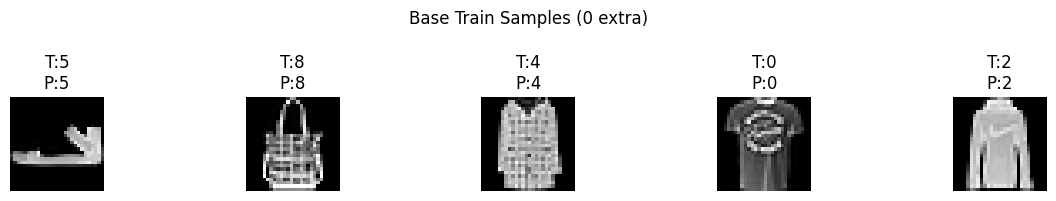

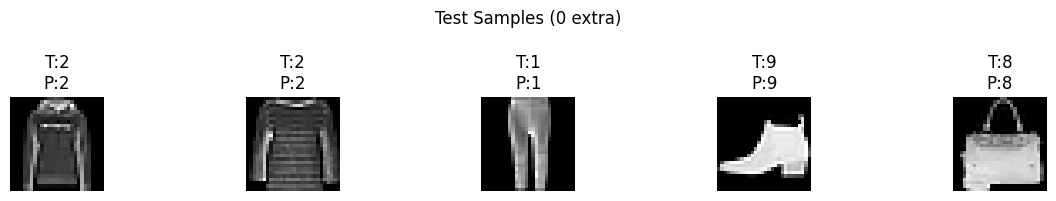

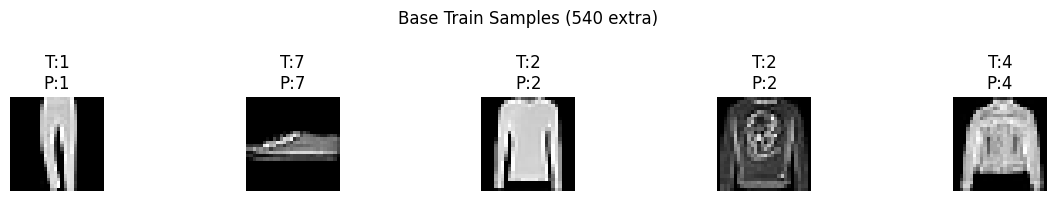

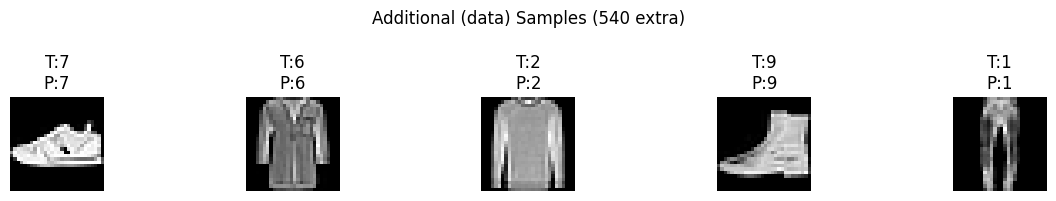

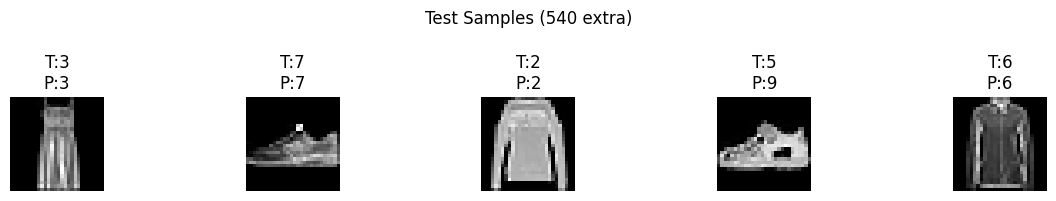

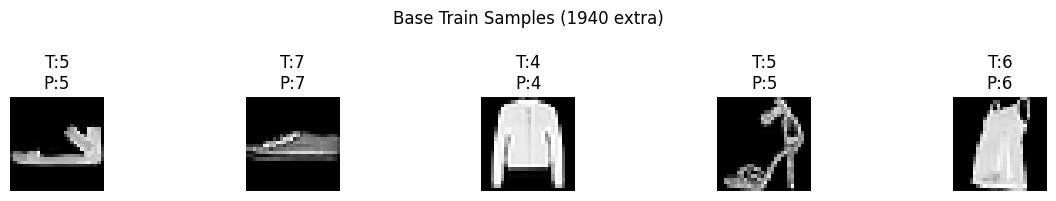

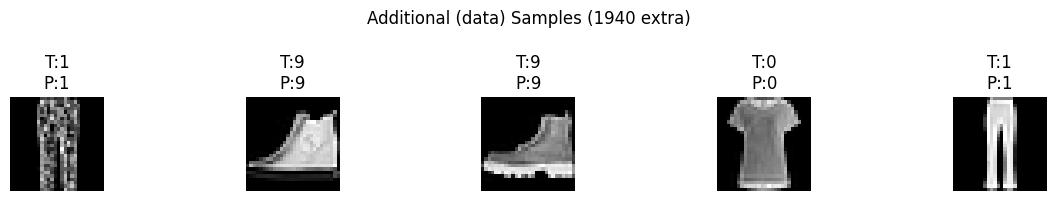

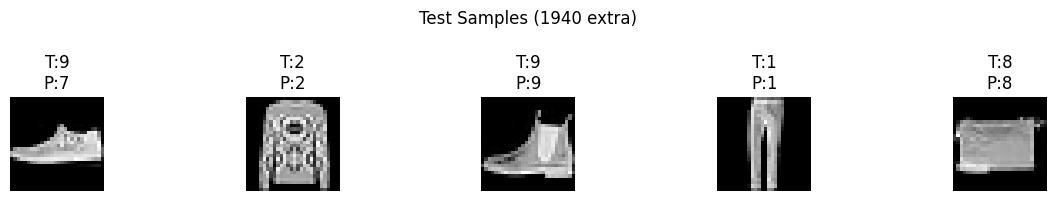

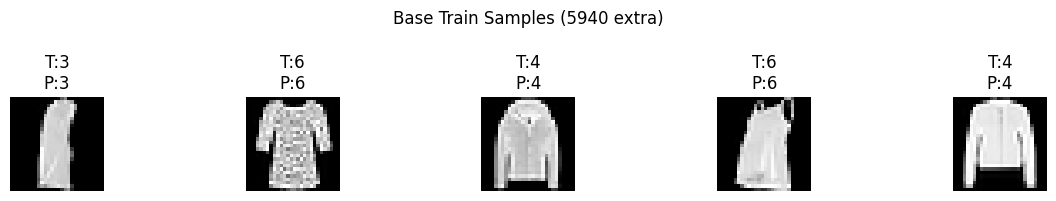

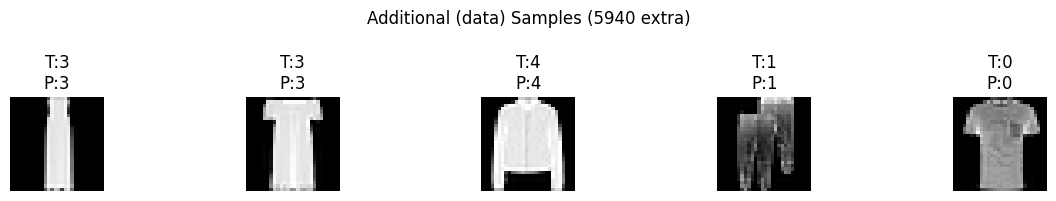

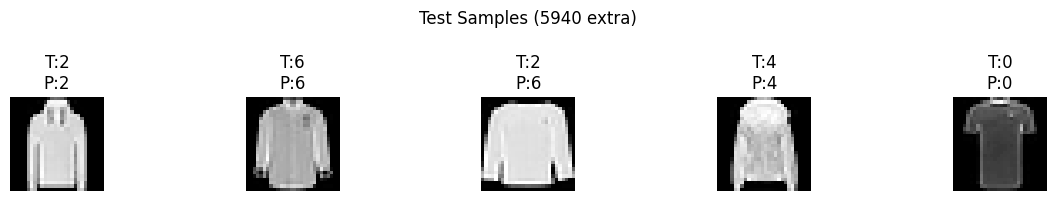

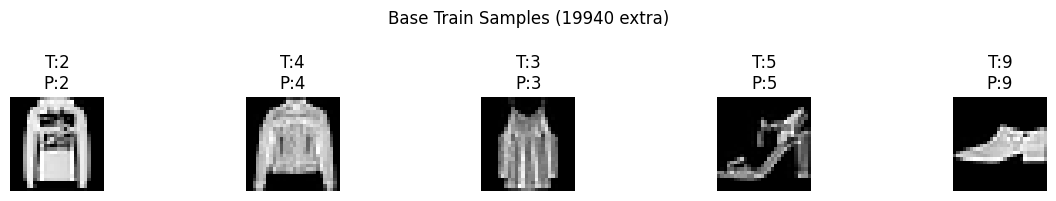

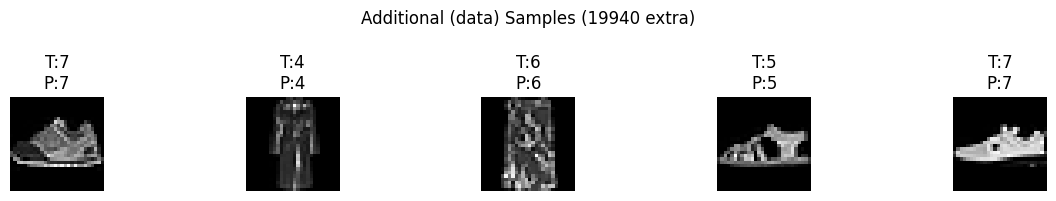

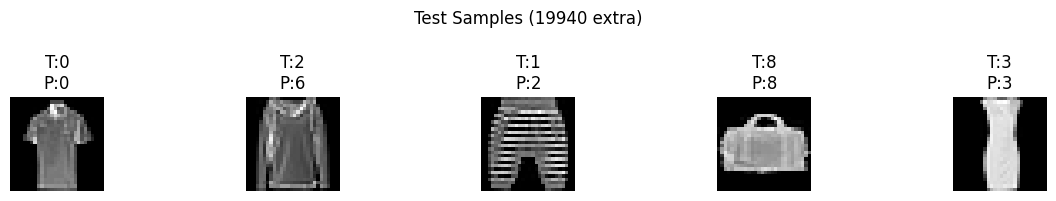

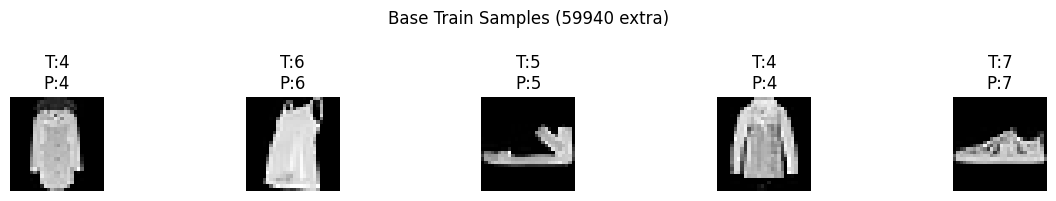

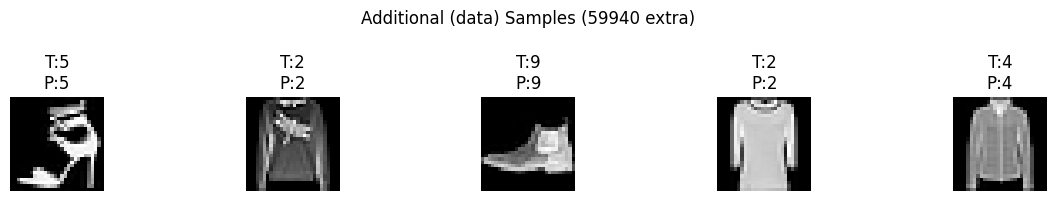

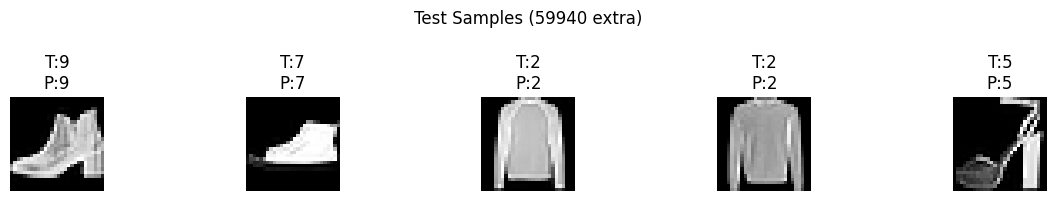

In [6]:
model_module.verify_model_results(
    all_models=all_models,
    x_base_train=x_base_train,
    y_base_train=y_base_train,
    x_additional=x_additional,
    y_additional=y_additional,
    x_test=x_test,
    y_test=y_test,
    dataset_quantities=dataset_quantities,
    dataset_type=dataset_type,
)

## Model Saving

In [7]:
# ====================================
# Save Datasets and Models
# ====================================
output_folder = "models_and_data"
# Save dataset (Possible to skip)
if save_generated_dataset:
    save_dataset(
        folder=output_folder,
        filename="dataset.pt",
        x_base_train=x_base_train,
        y_base_train=y_base_train,
        x_additional=x_additional,
        y_additional=y_additional,
        x_test=x_test,
        y_test=y_test,
        dataset_quantities=dataset_quantities,
        dataset_type=dataset_type,
    )
    print(f"Saved dataset to {output_folder}/dataset.pt")

# Save trained models
if save_generated_models:
    for model_data in all_models:
        filename = f"model_additional_{model_data['additional_data']}.pt"
        save_model(
            folder=output_folder,
            filename=filename,
            model=model_data["model"],
            train_loss=model_data["train_loss"],
            train_accs=model_data["train_accs"],
            test_loss=model_data["test_loss"],
            test_accs=model_data["test_accs"],
            additional_data=model_data["additional_data"],
            dataset_type=model_data["dataset_type"],
        )
        print(f"Saved model: {output_folder}/{filename}")

✅ Dataset saved to models_and_data\dataset.pt
Saved dataset to models_and_data/dataset.pt
✅ Model saved to models_and_data\model_additional_0.pt
Saved model: models_and_data/model_additional_0.pt
✅ Model saved to models_and_data\model_additional_540.pt
Saved model: models_and_data/model_additional_540.pt
✅ Model saved to models_and_data\model_additional_1940.pt
Saved model: models_and_data/model_additional_1940.pt
✅ Model saved to models_and_data\model_additional_5940.pt
Saved model: models_and_data/model_additional_5940.pt
✅ Model saved to models_and_data\model_additional_19940.pt
Saved model: models_and_data/model_additional_19940.pt
✅ Model saved to models_and_data\model_additional_59940.pt
Saved model: models_and_data/model_additional_59940.pt
